In [1]:
import pandas as pd
import numpy as np

from collections import Counter

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

pd.options.display.max_columns=999

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.size

10692

In [5]:
# Outlier detection 
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    
    I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an 
    interquartile range comprised between the 1st and 3rd quartile of the distribution 
    values (IQR). An outlier is a row that have a feature value outside the (IQR +- an 
    outlier step).
    
    source: 
    https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

D:\Programs\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [6]:
print(train.loc[Outliers_to_drop].size)
train.loc[Outliers_to_drop] # Show the outliers rows

120


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [7]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [8]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### Join train and test data

In [9]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0, sort=False).reset_index(drop=True)

In [10]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
print(train.shape)
print(test.shape)
print(dataset.shape)
print(train_len)

(881, 12)
(418, 11)
(1299, 12)
881


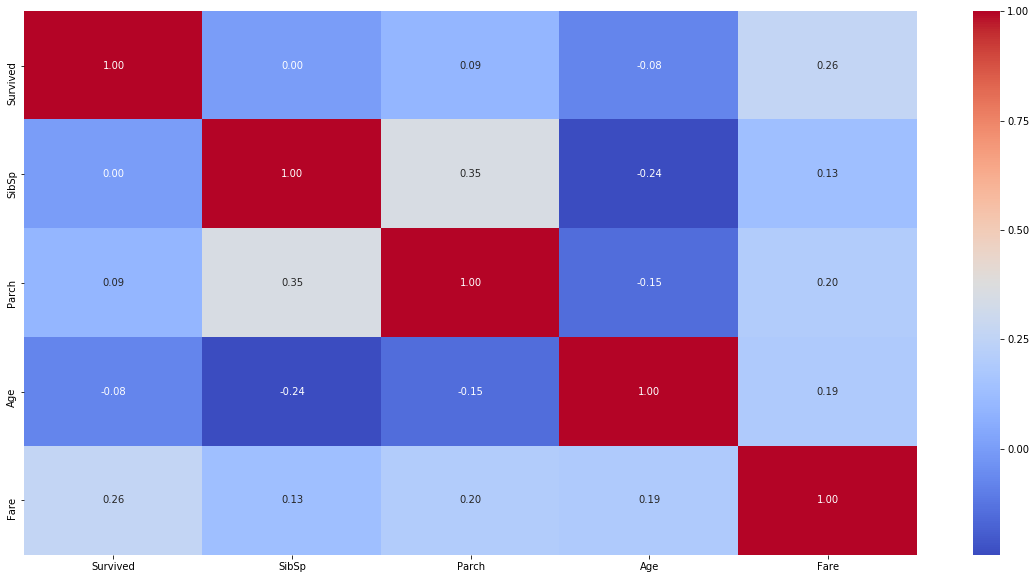

In [12]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
plt.figure(figsize=(20,10))
g = sns.heatmap(dataset[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
g;

D:\Programs\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


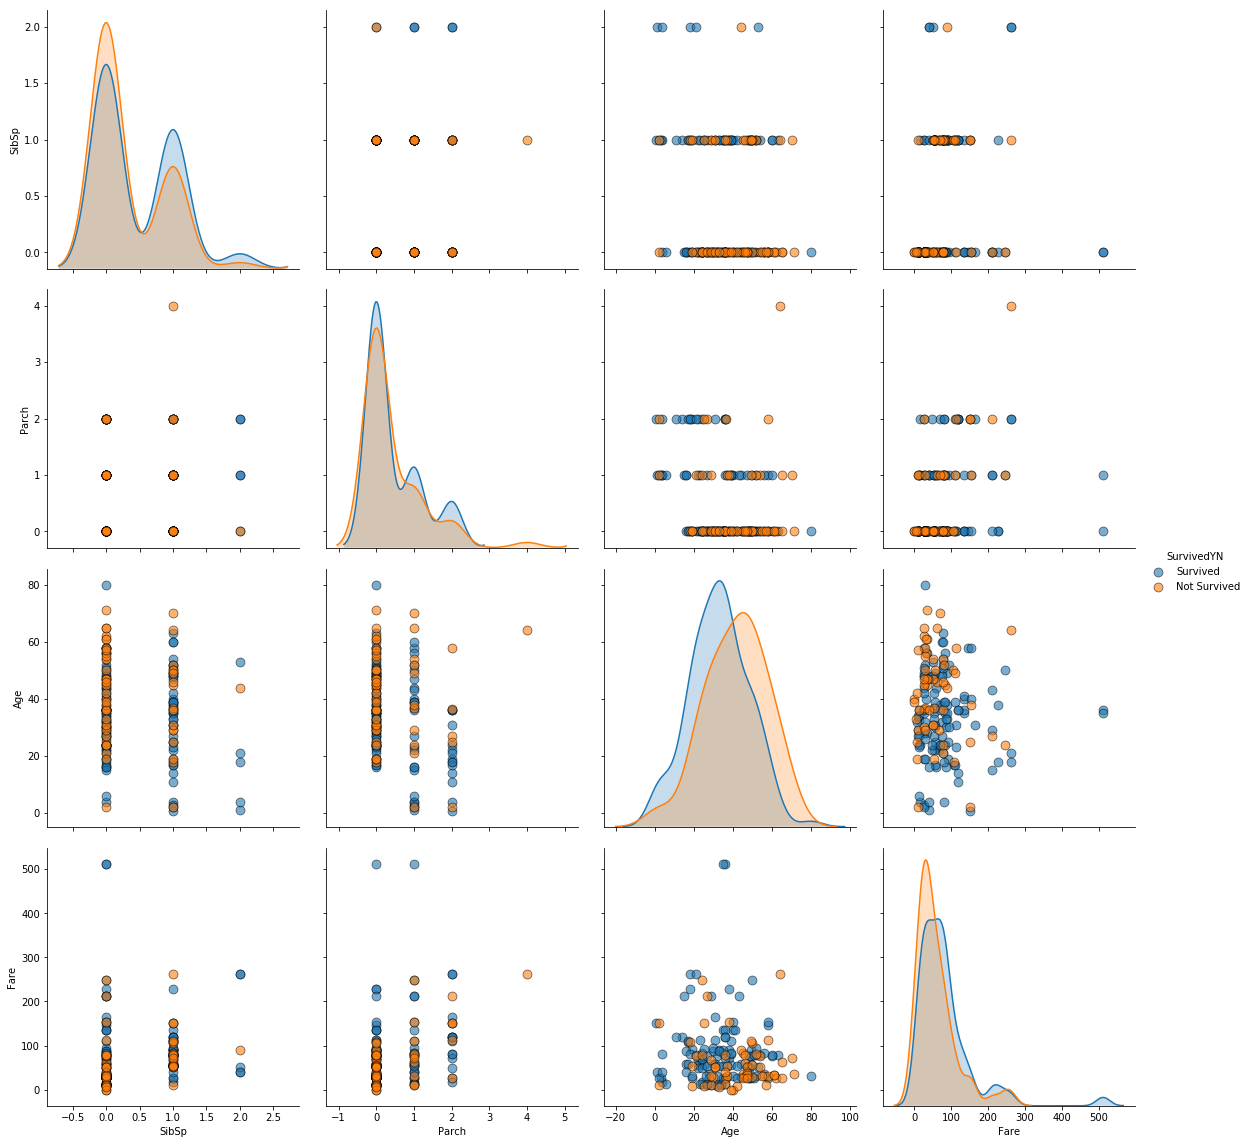

In [13]:
# just for the plot:
dataset['SurvivedYN'] = np.where(dataset['Survived']==0, 'Not Survived', 'Survived')

# straight forward:
# sns.pairplot(train[['SibSp', 'Parch', 'Age', 'Fare', 'Survived']].dropna(), hue='Survived')

sns.pairplot(dataset.dropna(), hue = 'SurvivedYN', diag_kind = 'kde',
             vars = ['SibSp', 'Parch', 'Age', 'Fare'],
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4);

In [14]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
SurvivedYN        0
dtype: int64

#### Name - Extraction of Title

In [15]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [16]:
def title_extraction(dataset):
    dataset_title = pd.Series([i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]])
    # Replace
    dataset_title = dataset_title.replace(['Lady', 'the Countess','Countess'], 'Mrs') # just an assumption
    dataset_title = dataset_title.replace(['Dr', 'Rev', 'Col', 'Major', 'Sir', 'Capt'], 'HighGent')
    dataset_title = dataset_title.replace(['Mlle', 'Ms', 'Mme', 'Dona'], 'Miss')
    dataset_title = dataset_title.replace(['Don', 'Jonkheer'], 'Mr')
    return dataset_title

dataset['Title'] = title_extraction(dataset)

In [17]:
dataset['Title'].value_counts()

Mr          755
Miss        261
Mrs         199
Master       60
HighGent     24
Name: Title, dtype: int64

## Missing Values

https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87


In [18]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
SurvivedYN        0
Title             0
dtype: int64

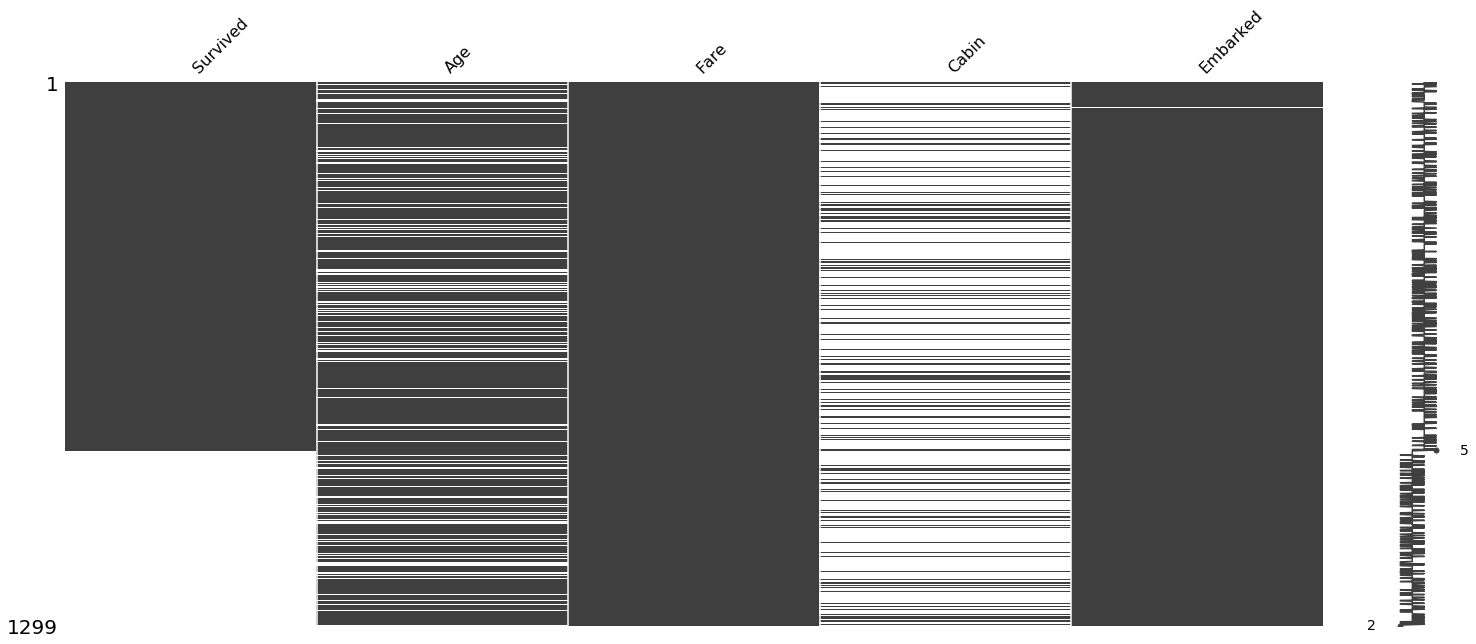

In [19]:
missingdata_df = dataset.columns[dataset.isnull().any()].tolist()
msno.matrix(dataset[missingdata_df])

In [20]:
missingdata_df

['Survived', 'Age', 'Fare', 'Cabin', 'Embarked']

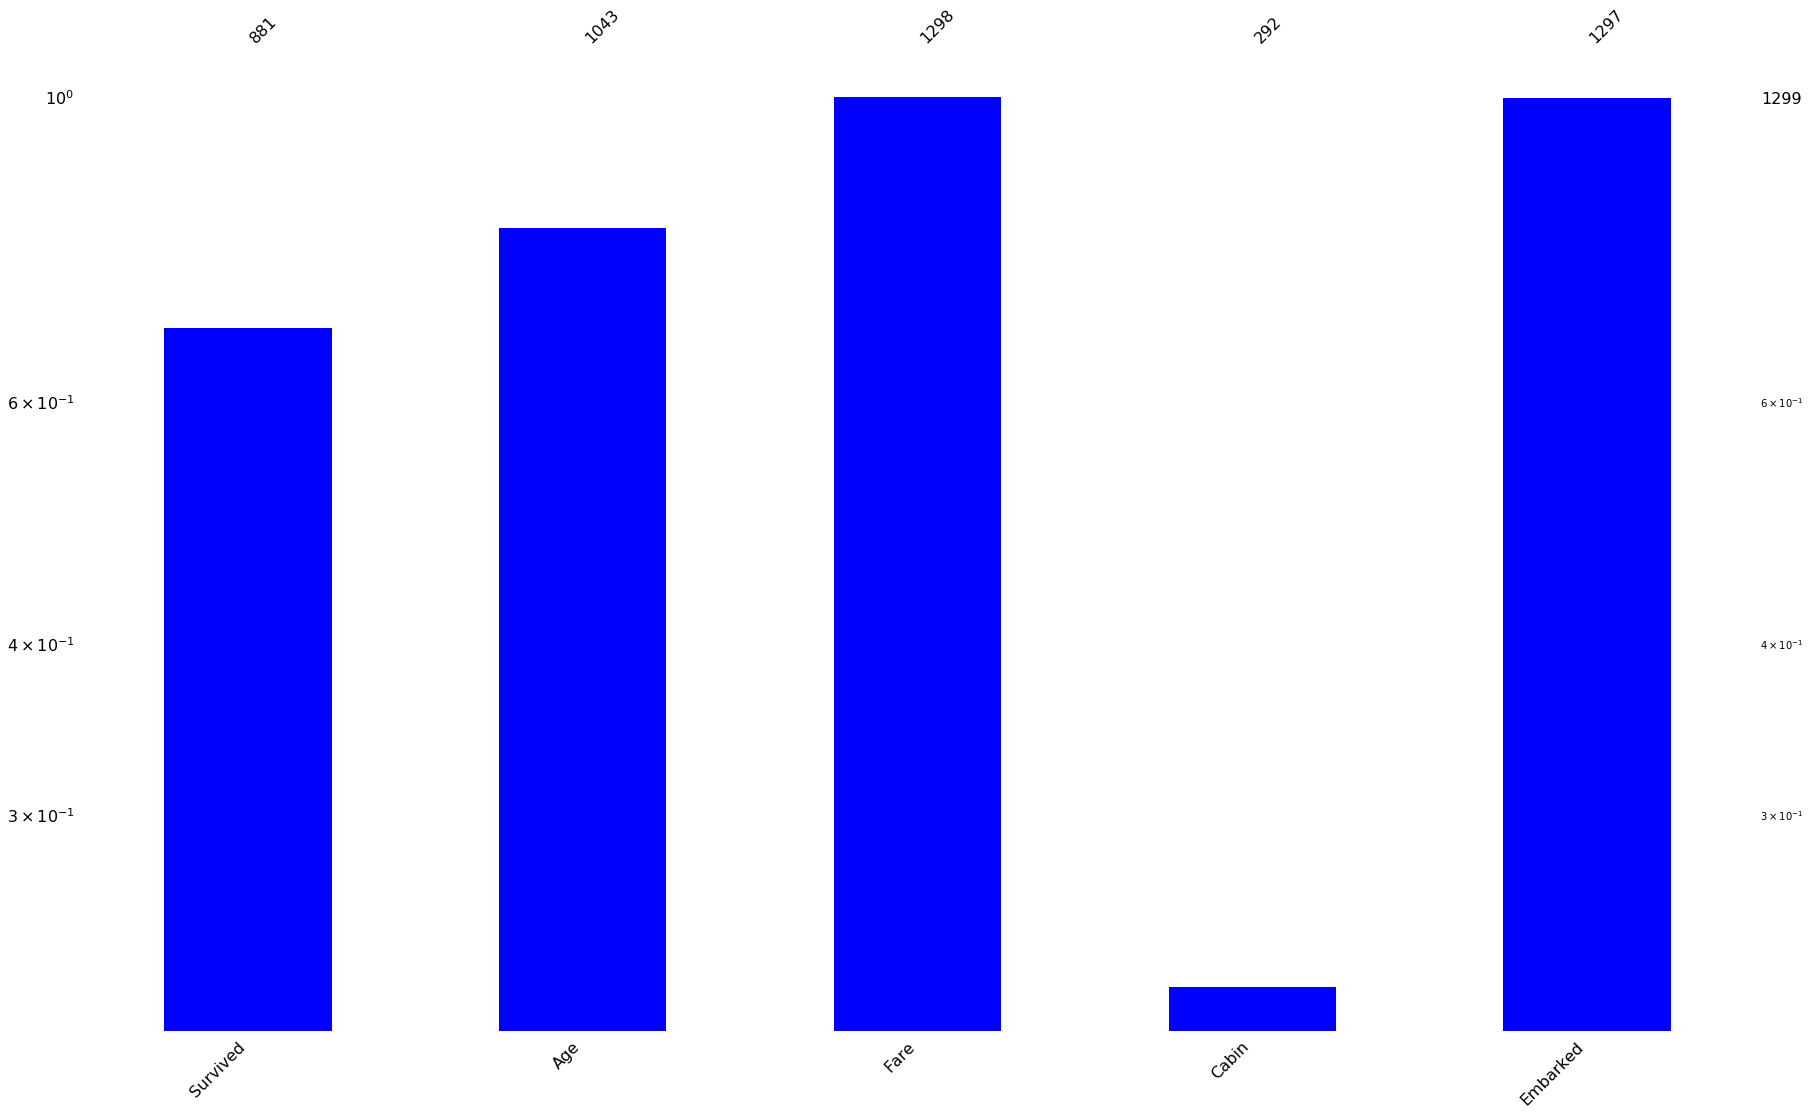

In [21]:
msno.bar(dataset[missingdata_df], color="blue", log=True, figsize=(30,18))

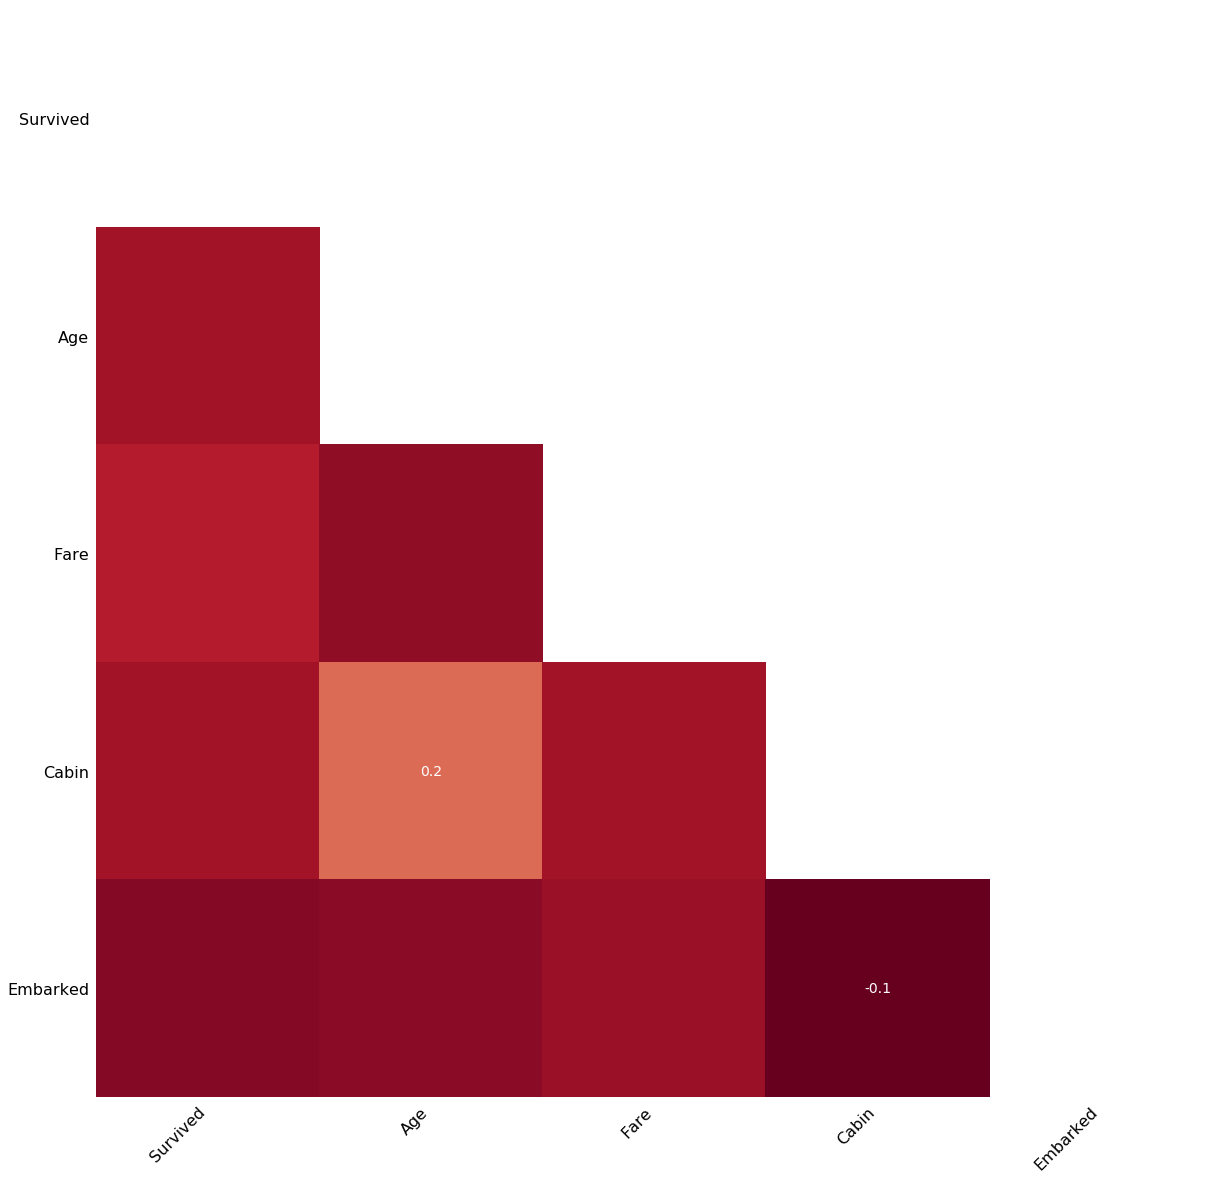

In [22]:
msno.heatmap(dataset[missingdata_df], figsize=(20,20))

Finally, a simple correlation heatmap is shown below. This map describes the degree of nullity relationship between the different features. The range of this nullity correlation is from -1 to 1 (-1 ≤ R ≤ 1). Features with no missing value are excluded in the heatmap. If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed. Also, a perfect positive nullity correlation (R=1) indicates when the first feature and the second feature both have corresponding missing values while a perfect negative nullity correlation (R=-1) means that one of the features is missing and the second is not missing.

#### Embarked

In [23]:
dataset['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [24]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')
dataset['Embarked'].value_counts()

S    906
C    270
Q    123
Name: Embarked, dtype: int64

#### Cabin

In [25]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [26]:
# remember:  'X123'[0] = 'X'
dataset['ShipLevel'] = [i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']]
dataset['CabinNum'] = [i[1:].split(' ')[0] if not pd.isnull(i) else '??' for i in dataset['Cabin']]

In [27]:
dataset['CabinNum'].dtype

dtype('O')

In [28]:
dataset.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
SurvivedYN      object
Title           object
ShipLevel       object
CabinNum        object
dtype: object

In [29]:
dataset['CabinNum'] = pd.to_numeric(dataset['CabinNum'], errors='coerce')
dataset['CabinNum'].isnull().sum()

1020

In [30]:
dataset['CabinNum'].head(20)

0       NaN
1      85.0
2       NaN
3     123.0
4       NaN
5       NaN
6      46.0
7       NaN
8       NaN
9       NaN
10      6.0
11    103.0
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
Name: CabinNum, dtype: float64

In [31]:
dataset['CabinNum'].shape

(1299,)

In [32]:
CabinLabels = ["{0}_{1}".format(i, i + 49) for i in range(0, 150, 50)]
#CabinLabels.append('unknownLoc')

In [33]:
CabinLabels

['0_49', '50_99', '100_149']

In [34]:
dataset['CabinNum'] = pd.cut(dataset['CabinNum'], 3, labels=CabinLabels)

In [35]:
dataset['CabinNum'].value_counts()

0_49       167
50_99       80
100_149     32
Name: CabinNum, dtype: int64

In [36]:
dataset['CabinNum']

0           NaN
1         50_99
2           NaN
3       100_149
4           NaN
5           NaN
6          0_49
7           NaN
8           NaN
9           NaN
10         0_49
11      100_149
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21        50_99
22          NaN
23         0_49
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
         ...   
1269        NaN
1270        NaN
1271       0_49
1272       0_49
1273        NaN
1274        NaN
1275        NaN
1276       0_49
1277        NaN
1278       0_49
1279        NaN
1280        NaN
1281       0_49
1282        NaN
1283        NaN
1284        NaN
1285       0_49
1286       0_49
1287        NaN
1288      50_99
1289        NaN
1290        NaN
1291        NaN
1292      50_99
1293        NaN
1294        NaN
1295    100_149
1296        NaN
1297        NaN
1298        NaN
Name: CabinNum, Length: 

In [37]:
dataset['CabinNum'] = dataset['CabinNum'].cat.add_categories(['unknownLoc'])

In [38]:
dataset['CabinNum']

0           NaN
1         50_99
2           NaN
3       100_149
4           NaN
5           NaN
6          0_49
7           NaN
8           NaN
9           NaN
10         0_49
11      100_149
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21        50_99
22          NaN
23         0_49
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
         ...   
1269        NaN
1270        NaN
1271       0_49
1272       0_49
1273        NaN
1274        NaN
1275        NaN
1276       0_49
1277        NaN
1278       0_49
1279        NaN
1280        NaN
1281       0_49
1282        NaN
1283        NaN
1284        NaN
1285       0_49
1286       0_49
1287        NaN
1288      50_99
1289        NaN
1290        NaN
1291        NaN
1292      50_99
1293        NaN
1294        NaN
1295    100_149
1296        NaN
1297        NaN
1298        NaN
Name: CabinNum, Length: 

In [39]:
dataset['CabinNum'] = dataset['CabinNum'].fillna('unknownLoc')

In [40]:
dataset['CabinNum'].value_counts()

unknownLoc    1020
0_49           167
50_99           80
100_149         32
Name: CabinNum, dtype: int64

In [41]:
dataset['ShipLevel'].value_counts()

X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: ShipLevel, dtype: int64

In [42]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SurvivedYN,Title,ShipLevel,CabinNum
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Not Survived,Mr,X,unknownLoc
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Survived,Mrs,C,50_99
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Survived,Miss,X,unknownLoc
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Survived,Mrs,C,100_149
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Not Survived,Mr,X,unknownLoc


#### Age

In [43]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          0
SurvivedYN        0
Title             0
ShipLevel         0
CabinNum          0
dtype: int64

In [44]:
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)
dataset['Age_impute_median'] = dataset['Age'] # keep "Age" as it is

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & 
                               (dataset['Parch'] == dataset.iloc[i]["Parch"]) & 
                               (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age_impute_median'].iloc[i] = age_pred
    else :
        dataset['Age_impute_median'].iloc[i] = age_med

D:\Programs\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [45]:
dataset.isnull().sum()

PassengerId             0
Survived              418
Pclass                  0
Name                    0
Sex                     0
Age                   256
SibSp                   0
Parch                   0
Ticket                  0
Fare                    1
Cabin                1007
Embarked                0
SurvivedYN              0
Title                   0
ShipLevel               0
CabinNum                0
Age_impute_median       0
dtype: int64

#### Fare

In [46]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

In [47]:
dataset.isnull().sum()

PassengerId             0
Survived              418
Pclass                  0
Name                    0
Sex                     0
Age                   256
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                1007
Embarked                0
SurvivedYN              0
Title                   0
ShipLevel               0
CabinNum                0
Age_impute_median       0
dtype: int64

In [48]:
dataset['ShipLevel'].value_counts()

X    1007
C      91
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: ShipLevel, dtype: int64

In [49]:
dataset['CabinNum'].value_counts()

unknownLoc    1020
0_49           167
50_99           80
100_149         32
Name: CabinNum, dtype: int64

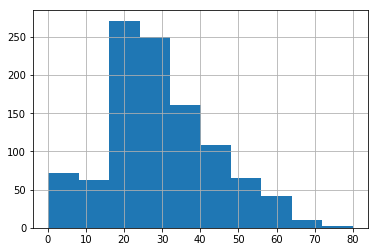

In [50]:
dataset['Age'].hist()

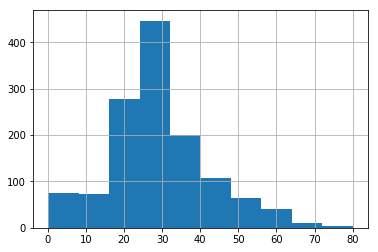

In [51]:
dataset['Age_impute_median'].hist()

In [52]:
# g = sns.jointplot(x='Age', y='Age_impute_median', data=dataset)
# Age has missing values....joinplot doesn't make sense

In [53]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SurvivedYN,Title,ShipLevel,CabinNum,Age_impute_median
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Not Survived,Mr,X,unknownLoc,22.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Survived,Mrs,C,50_99,38.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Survived,Miss,X,unknownLoc,26.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Survived,Mrs,C,100_149,35.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Not Survived,Mr,X,unknownLoc,35.0


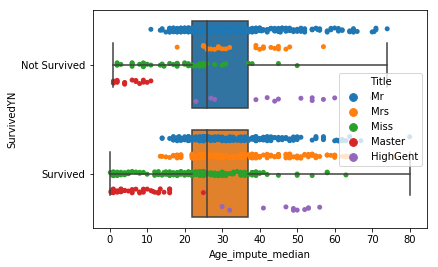

In [54]:
# in general: x...continuous     y...categorical
ax = sns.boxplot(x="Age_impute_median", y="SurvivedYN", data=dataset, whis=np.inf)
ax = sns.stripplot(x="Age_impute_median", y="SurvivedYN", data=dataset, hue='Title', dodge=True, zorder=1, jitter=True)#, color=".3")

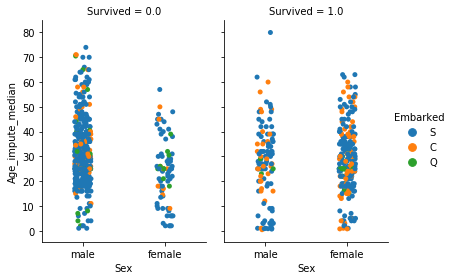

In [55]:
g = sns.catplot(x="Sex", y="Age_impute_median",
                hue="Embarked", col="Survived",
                data=dataset, kind="strip",
                jitter=True,
                height=4, aspect=.7);

In [56]:
sns.__version__

'0.9.0'

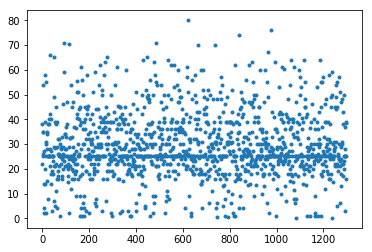

In [57]:
plt.plot(dataset['Age_impute_median'], '.')

## Feature Engineering

```python
%%time
for type_ids in [['item_id'], ['shop_id'], ['cats'], ['item_id', 'shop_id']]:
    for column_id in ['item_price', 'item_cnt_month']:
        mean_df = train_df[type_ids + [column_id]].groupby(type_ids).agg(np.mean).reset_index()
        mean_df.rename(columns={column_id: "mean_of_"+column_id+"_groupby_"+"_".join(type_ids)}, inplace=True)
        
        train_df = pd.merge(train_df, mean_df, on=type_ids, how='left')
        test_df = pd.merge(test_df, mean_df, on=type_ids, how='left')
```

In [58]:
ttdata = dataset[~dataset['Survived'].isnull()]

In [59]:
mean_df = ttdata[['Embarked', 'Survived']].groupby(['Embarked']).agg(np.mean).reset_index()
# also works: 
# mean_test = ttdata[['Embarked', 'Survived']].groupby(['Embarked'])['Survived'].mean()
mean_df

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.341195


In [60]:
mean_df.rename(columns={'Survived':'Embarked_likelihood_mean_enc'}, inplace=True)
mean_df

,Embarked,Embarked_likelihood_mean_enc
0,C,0.553571
1,Q,0.389610
2,S,0.341195


In [61]:
tt = pd.merge(dataset, mean_df, on='Embarked', how='left')
tt.tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SurvivedYN,Title,ShipLevel,CabinNum,Age_impute_median,Embarked_likelihood_mean_enc
1289,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q,Survived,Miss,X,unknownLoc,25.0,0.389610
1290,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,Survived,Miss,X,unknownLoc,3.0,0.341195
1291,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q,Survived,Miss,X,unknownLoc,25.0,0.389610
1292,1303,NaN,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q,Survived,Mrs,C,50_99,37.0,0.389610
1293,1304,NaN,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S,Survived,Miss,X,unknownLoc,28.0,0.341195
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Survived,Mr,X,unknownLoc,25.0,0.341195
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Survived,Miss,C,100_149,39.0,0.553571
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Survived,Mr,X,unknownLoc,38.5,0.341195
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Survived,Mr,X,unknownLoc,25.0,0.341195
1298,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,Survived,Master,X,unknownLoc,16.0,0.553571


In [62]:
mean_test = ttdata[['Embarked', 'Survived']].groupby(['Embarked']).agg(['size', 'count', np.sum])
mean_test

Survived             
             size count    sum
Embarked                      
C             168   168   93.0
Q              77    77   30.0
S             636   636  217.0

In [63]:
import math

def mean_encoding_weight_of_evidence(data):
    number_of_ones = np.sum(data['Survived'])
    number_of_zeros = data.shape[0] - number_of_ones
    
    data['weight_of_evidence'] = math.log(number_of_ones/number_of_zeros)*100
    return data

def mean_encoding_difference(data):
    number_of_ones = np.sum(data['Survived'])
    number_of_zeros = data.shape[0] - number_of_ones
    
    data['mean_enc_diff'] = number_of_ones - number_of_zeros
    return data

In [64]:
mean_test = ttdata[['Embarked', 'Survived']].groupby(['Embarked']).apply(mean_encoding_weight_of_evidence)
mean_test.head()

,Embarked,Survived,weight_of_evidence
0,S,0.0,-65.797357
1,C,1.0,21.511138
2,S,1.0,-65.797357
3,S,1.0,-65.797357
4,S,0.0,-65.797357


In [65]:
number_of_ones  = lambda x: np.sum(x['Survived'])
number_of_zeros = lambda x: x.shape[0] - np.sum(x['Survived'])
difference = lambda x: np.sum(x['Survived']) - (x.shape[0] - np.sum(x['Survived']))

In [66]:
mean_test = ttdata[['Embarked', 'Survived']].groupby(['Embarked']).agg(difference)
mean_test.head()

,Survived
Embarked,
C,18.0
Q,-17.0
S,-202.0


In [67]:
# Let's do categorical features

from sklearn import preprocessing

def frequency_encoding(data, col):
    encoding_temp = data.groupby(col).size()  
    # also works with:   dataset['Embarked'].value_counts()
    
    encoding_temp = encoding_temp / len(data)
    data[col+'_freq_enc'] = data[col].map(encoding_temp)
    return data


def likelihood_mean_encoding(data, col, col_target):
    mean_df = data[[col, col_target]].groupby([col]).agg(np.mean).reset_index()  
    # also works: mean_test = ttdata[['Embarked', 'Survived']].groupby(['Embarked'])['Survived'].mean()
    
    mean_df.rename(columns={col_target:str(col + '_likelihood_mean_enc')}, inplace=True)  # cosmetic
    data = pd.merge(data, mean_df, on=col, how='left')
    return data



In [68]:
categorical_feats = ['Pclass', 'Sex', 'Embarked', 'Title', 'ShipLevel', 'CabinNum']
for col in categorical_feats:
    # ---1--- convert into category columns - makes life easier with pandas
    dataset[col] = dataset[col].astype('category')
    # ---2---  frequency encoding
    dataset = frequency_encoding(dataset, col)
    # ---3--- likelihood mean encoding
    dataset = likelihood_mean_encoding(dataset, col, 'Survived')
    # ---4--- one hot encoding / get dummies
    # col_temp = pd.get_dummies(dataset[col], prefix=str('dummy_' + col))
    # dataset = pd.concat([dataset, col_temp], axis=1)
    # dataset = dataset.drop(col, axis=1)

In [69]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SurvivedYN,Title,ShipLevel,CabinNum,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Not Survived,Mr,X,unknownLoc,22.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Survived,Mrs,C,50_99,38.0,0.246343,0.629108,0.354888,0.747573,0.207852,0.553571,0.153195,0.795276,0.070054,0.589286,0.061586,0.641509
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Survived,Miss,X,unknownLoc,26.0,0.540416,0.245868,0.354888,0.747573,0.697460,0.341195,0.200924,0.712707,0.775212,0.302941,0.785219,0.303779
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Survived,Mrs,C,100_149,35.0,0.246343,0.629108,0.354888,0.747573,0.697460,0.341195,0.153195,0.795276,0.070054,0.589286,0.024634,0.666667
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Not Survived,Mr,X,unknownLoc,35.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779


In [70]:
dataset.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SurvivedYN,Title,ShipLevel,CabinNum,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Survived,Mr,X,unknownLoc,25.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779
1295,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Survived,Miss,C,100_149,39.0,0.246343,0.629108,0.354888,0.747573,0.207852,0.553571,0.200924,0.712707,0.070054,0.589286,0.024634,0.666667
1296,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Survived,Mr,X,unknownLoc,38.5,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Survived,Mr,X,unknownLoc,25.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779
1298,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,Survived,Master,X,unknownLoc,16.0,0.540416,0.245868,0.645112,0.190559,0.207852,0.553571,0.046189,0.589744,0.775212,0.302941,0.785219,0.303779


In [71]:
PassengerId = dataset[dataset['Survived'].isnull()]['PassengerId']

In [72]:
PassengerId.shape

(418,)

In [73]:
col_not_needed = ['PassengerId', 'Name', 'Age', 'Ticket', 'Cabin', 'SurvivedYN' ]

dataset.drop(col_not_needed, axis=1, inplace=True)

In [74]:
dataset.isnull().sum()

Survived                         418
Pclass                             0
Sex                                0
SibSp                              0
Parch                              0
Fare                               0
Embarked                           0
Title                              0
ShipLevel                          0
CabinNum                           0
Age_impute_median                  0
Pclass_freq_enc                    0
Pclass_likelihood_mean_enc         0
Sex_freq_enc                       0
Sex_likelihood_mean_enc            0
Embarked_freq_enc                  0
Embarked_likelihood_mean_enc       0
Title_freq_enc                     0
Title_likelihood_mean_enc          0
ShipLevel_freq_enc                 0
ShipLevel_likelihood_mean_enc      0
CabinNum_freq_enc                  0
CabinNum_likelihood_mean_enc       0
dtype: int64

In [75]:
dataset.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,ShipLevel,CabinNum,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc
0,0.0,3,male,1,0,7.2500,S,Mr,X,unknownLoc,22.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779
1,1.0,1,female,1,0,71.2833,C,Mrs,C,50_99,38.0,0.246343,0.629108,0.354888,0.747573,0.207852,0.553571,0.153195,0.795276,0.070054,0.589286,0.061586,0.641509
2,1.0,3,female,0,0,7.9250,S,Miss,X,unknownLoc,26.0,0.540416,0.245868,0.354888,0.747573,0.697460,0.341195,0.200924,0.712707,0.775212,0.302941,0.785219,0.303779
3,1.0,1,female,1,0,53.1000,S,Mrs,C,100_149,35.0,0.246343,0.629108,0.354888,0.747573,0.697460,0.341195,0.153195,0.795276,0.070054,0.589286,0.024634,0.666667
4,0.0,3,male,0,0,8.0500,S,Mr,X,unknownLoc,35.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779


In [76]:
dataset.dtypes

Survived                          float64
Pclass                           category
Sex                              category
SibSp                               int64
Parch                               int64
Fare                              float64
Embarked                         category
Title                            category
ShipLevel                        category
CabinNum                         category
Age_impute_median                 float64
Pclass_freq_enc                   float64
Pclass_likelihood_mean_enc        float64
Sex_freq_enc                      float64
Sex_likelihood_mean_enc           float64
Embarked_freq_enc                 float64
Embarked_likelihood_mean_enc      float64
Title_freq_enc                    float64
Title_likelihood_mean_enc         float64
ShipLevel_freq_enc                float64
ShipLevel_likelihood_mean_enc     float64
CabinNum_freq_enc                 float64
CabinNum_likelihood_mean_enc      float64
dtype: object

In [77]:
import os

In [78]:
categorical_feats

['Pclass', 'Sex', 'Embarked', 'Title', 'ShipLevel', 'CabinNum']

In [79]:
dataset.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Title,ShipLevel,CabinNum,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc
0,0.0,3,male,1,0,7.2500,S,Mr,X,unknownLoc,22.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779
1,1.0,1,female,1,0,71.2833,C,Mrs,C,50_99,38.0,0.246343,0.629108,0.354888,0.747573,0.207852,0.553571,0.153195,0.795276,0.070054,0.589286,0.061586,0.641509
2,1.0,3,female,0,0,7.9250,S,Miss,X,unknownLoc,26.0,0.540416,0.245868,0.354888,0.747573,0.697460,0.341195,0.200924,0.712707,0.775212,0.302941,0.785219,0.303779
3,1.0,1,female,1,0,53.1000,S,Mrs,C,100_149,35.0,0.246343,0.629108,0.354888,0.747573,0.697460,0.341195,0.153195,0.795276,0.070054,0.589286,0.024634,0.666667
4,0.0,3,male,0,0,8.0500,S,Mr,X,unknownLoc,35.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779


In [80]:
from sklearn import preprocessing

#for column in categorical_feats:
    #le = preprocessing.OneHotEncoder()
    #dataset[column] = le.fit_transform(dataset[column])
 #   dataset[column] = pd.get_dummies()
dataset = pd.get_dummies(dataset, columns=categorical_feats)

In [81]:
dataset.head()

,Survived,SibSp,Parch,Fare,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_HighGent,Title_Master,Title_Miss,Title_Mr,Title_Mrs,ShipLevel_A,ShipLevel_B,ShipLevel_C,ShipLevel_D,ShipLevel_E,ShipLevel_F,ShipLevel_G,ShipLevel_T,ShipLevel_X,CabinNum_0_49,CabinNum_50_99,CabinNum_100_149,CabinNum_unknownLoc
0,0.0,1,0,7.2500,22.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1.0,1,0,71.2833,38.0,0.246343,0.629108,0.354888,0.747573,0.207852,0.553571,0.153195,0.795276,0.070054,0.589286,0.061586,0.641509,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
2,1.0,0,0,7.9250,26.0,0.540416,0.245868,0.354888,0.747573,0.697460,0.341195,0.200924,0.712707,0.775212,0.302941,0.785219,0.303779,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1.0,1,0,53.1000,35.0,0.246343,0.629108,0.354888,0.747573,0.697460,0.341195,0.153195,0.795276,0.070054,0.589286,0.024634,0.666667,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
4,0.0,0,0,8.0500,35.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [82]:
def prepare_data_Xy(data):
    X = data[~data['Survived'].isnull()]
    y = X['Survived']
    X = X.drop(['Survived'], axis=1)
    return X, y

def prepare_kaggle_test_X(data):
    X = data[data['Survived'].isnull()]
    X = X.drop(['Survived'], axis=1)
    return X

X, y = prepare_data_Xy(dataset)
X_kaggle_test = prepare_kaggle_test_X(dataset)

In [83]:
print(X.shape)
print(y.shape)

(881, 42)
(881,)


In [84]:
dataset_featureengineered = pd.concat([X, y], axis=1)

In [85]:
dataset_featureengineered.shape

(881, 43)

In [86]:
dataset_featureengineered.head()

,SibSp,Parch,Fare,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_HighGent,Title_Master,Title_Miss,Title_Mr,Title_Mrs,ShipLevel_A,ShipLevel_B,ShipLevel_C,ShipLevel_D,ShipLevel_E,ShipLevel_F,ShipLevel_G,ShipLevel_T,ShipLevel_X,CabinNum_0_49,CabinNum_50_99,CabinNum_100_149,CabinNum_unknownLoc,Survived
0,1,0,7.2500,22.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.0
1,1,0,71.2833,38.0,0.246343,0.629108,0.354888,0.747573,0.207852,0.553571,0.153195,0.795276,0.070054,0.589286,0.061586,0.641509,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1.0
2,0,0,7.9250,26.0,0.540416,0.245868,0.354888,0.747573,0.697460,0.341195,0.200924,0.712707,0.775212,0.302941,0.785219,0.303779,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1.0
3,1,0,53.1000,35.0,0.246343,0.629108,0.354888,0.747573,0.697460,0.341195,0.153195,0.795276,0.070054,0.589286,0.024634,0.666667,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1.0
4,0,0,8.0500,35.0,0.540416,0.245868,0.645112,0.190559,0.697460,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.0


In [87]:
y.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [88]:
# scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_kaggle_test_scaled = scaler.transform(X_kaggle_test)

In [89]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_kaggle_test_scaled = pd.DataFrame(X_kaggle_test_scaled, columns=X_kaggle_test.columns)

In [90]:
X_scaled.head()

,SibSp,Parch,Fare,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_HighGent,Title_Master,Title_Miss,Title_Mr,Title_Mrs,ShipLevel_A,ShipLevel_B,ShipLevel_C,ShipLevel_D,ShipLevel_E,ShipLevel_F,ShipLevel_G,ShipLevel_T,ShipLevel_X,CabinNum_0_49,CabinNum_50_99,CabinNum_100_149,CabinNum_unknownLoc
0,0.625474,-0.458969,-0.497646,-0.536933,0.903338,-0.857915,0.734990,-0.734990,0.616404,-0.542232,0.830162,-0.815547,0.543430,-0.515492,0.528506,-0.528136,-0.564679,-0.513798,0.905675,-0.734990,0.734990,-0.485411,-0.309469,0.620661,-0.148465,-0.215217,-0.508499,0.843018,-0.410408,-0.131609,-0.237392,-0.260536,-0.197269,-0.194143,-0.12238,-0.067535,-0.03371,0.543680,-0.389402,-0.253001,-0.167346,0.529644
1,0.625474,-0.458969,0.837243,0.655787,-1.001900,1.489605,-1.360563,1.360563,-1.450025,2.032259,-1.192738,1.460109,-1.755003,1.263266,-2.009046,1.643212,1.770918,-0.513798,-1.104148,1.360563,-1.360563,2.060109,-0.309469,-1.611185,-0.148465,-0.215217,-0.508499,-1.186214,2.436598,-0.131609,-0.237392,3.838247,-0.197269,-0.194143,-0.12238,-0.067535,-0.03371,-1.839316,-0.389402,3.952549,-0.167346,-1.888059
2,-0.522532,-0.458969,-0.483574,-0.238753,0.903338,-0.857915,-1.360563,1.360563,0.616404,-0.542232,-0.967163,1.165597,0.543430,-0.515492,0.528506,-0.528136,-0.564679,-0.513798,0.905675,1.360563,-1.360563,-0.485411,-0.309469,0.620661,-0.148465,-0.215217,1.966571,-1.186214,-0.410408,-0.131609,-0.237392,-0.260536,-0.197269,-0.194143,-0.12238,-0.067535,-0.03371,0.543680,-0.389402,-0.253001,-0.167346,0.529644
3,0.625474,-0.458969,0.458180,0.432152,-1.001900,1.489605,-1.360563,1.360563,0.616404,-0.542232,-1.192738,1.460109,-1.755003,1.263266,-2.138623,1.804953,1.770918,-0.513798,-1.104148,1.360563,-1.360563,-0.485411,-0.309469,0.620661,-0.148465,-0.215217,-0.508499,-1.186214,2.436598,-0.131609,-0.237392,3.838247,-0.197269,-0.194143,-0.12238,-0.067535,-0.03371,-1.839316,-0.389402,-0.253001,5.975645,-1.888059
4,-0.522532,-0.458969,-0.480968,0.432152,0.903338,-0.857915,0.734990,-0.734990,0.616404,-0.542232,0.830162,-0.815547,0.543430,-0.515492,0.528506,-0.528136,-0.564679,-0.513798,0.905675,-0.734990,0.734990,-0.485411,-0.309469,0.620661,-0.148465,-0.215217,-0.508499,0.843018,-0.410408,-0.131609,-0.237392,-0.260536,-0.197269,-0.194143,-0.12238,-0.067535,-0.03371,0.543680,-0.389402,-0.253001,-0.167346,0.529644


In [91]:
# data for train/test-split 
X_scaled.to_csv('./data_featureengineered/Xdata_featureengineered.csv', index=False)
y.to_csv('./data_featureengineered/ydata_featureengineered.csv', index=False)
X_kaggle_test_scaled.to_csv('./data_featureengineered/X_kaggle_featureengineered.csv', index=False)

In [92]:
predictions = np.ones(PassengerId.shape[0], dtype=int)
predictions

# create submission file
# Generate Submission File 
PassengerId = test['PassengerId']
submission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
submission.to_csv("./submissions/2018-08-17_only_ones.csv", index=False)

In [93]:
predictions = np.zeros(PassengerId.shape[0], dtype=int)
predictions

# create submission file
# Generate Submission File 
PassengerId = test['PassengerId']
submission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
submission.to_csv("./submissions/2018-08-17_only_zeros.csv", index=False)

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [96]:
X_test.shape

(265, 42)

In [97]:
X_test.head()

,SibSp,Parch,Fare,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_HighGent,Title_Master,Title_Miss,Title_Mr,Title_Mrs,ShipLevel_A,ShipLevel_B,ShipLevel_C,ShipLevel_D,ShipLevel_E,ShipLevel_F,ShipLevel_G,ShipLevel_T,ShipLevel_X,CabinNum_0_49,CabinNum_50_99,CabinNum_100_149,CabinNum_unknownLoc
350,0,0,13.000,38.0,0.213241,0.472826,0.354888,0.747573,0.69746,0.341195,0.200924,0.712707,0.775212,0.302941,0.785219,0.303779,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
254,0,1,26.000,50.0,0.213241,0.472826,0.354888,0.747573,0.69746,0.341195,0.153195,0.795276,0.775212,0.302941,0.785219,0.303779,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
490,0,0,15.100,25.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
688,0,0,13.500,52.0,0.213241,0.472826,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
393,0,0,7.925,39.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [98]:
X_train.shape

(616, 42)

In [99]:
train.shape

(881, 12)

In [100]:
X_train.columns

Index(['SibSp', 'Parch', 'Fare', 'Age_impute_median', 'Pclass_freq_enc',
       'Pclass_likelihood_mean_enc', 'Sex_freq_enc', 'Sex_likelihood_mean_enc',
       'Embarked_freq_enc', 'Embarked_likelihood_mean_enc', 'Title_freq_enc',
       'Title_likelihood_mean_enc', 'ShipLevel_freq_enc',
       'ShipLevel_likelihood_mean_enc', 'CabinNum_freq_enc',
       'CabinNum_likelihood_mean_enc', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_HighGent', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'ShipLevel_A', 'ShipLevel_B', 'ShipLevel_C', 'ShipLevel_D',
       'ShipLevel_E', 'ShipLevel_F', 'ShipLevel_G', 'ShipLevel_T',
       'ShipLevel_X', 'CabinNum_0_49', 'CabinNum_50_99', 'CabinNum_100_149',
       'CabinNum_unknownLoc'],
      dtype='object')

-------

In [101]:
model_name = 'random_forest'

from sklearn import ensemble
from sklearn import pipeline

In [102]:
def instantiate_model(model_name):
    steps = [
        #('scaler', preprocessing.StandardScaler()),
    ]
    if model_name == 'random_forest':
        steps.append(('rf', ensemble.RandomForestClassifier()))
    else:
        raise ValueError('Unknown model name: %s' % model_name)
    return pipeline.Pipeline(steps)

In [103]:
instantiate_model(model_name)

Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [104]:
def get_model(name, X=None, Y=None, params=None):
    model = instantiate_model(name)
    
    
    if isinstance(X, pd.DataFrame) and (isinstance(Y, pd.DataFrame) or isinstance(Y, pd.Series)):
        #Y = Y if len(Y.columns) > 1 else Y.iloc[:,0]
        model.fit(X, Y)
    return model

In [105]:
X_train.head()

,SibSp,Parch,Fare,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_HighGent,Title_Master,Title_Miss,Title_Mr,Title_Mrs,ShipLevel_A,ShipLevel_B,ShipLevel_C,ShipLevel_D,ShipLevel_E,ShipLevel_F,ShipLevel_G,ShipLevel_T,ShipLevel_X,CabinNum_0_49,CabinNum_50_99,CabinNum_100_149,CabinNum_unknownLoc
90,1,0,61.1750,46.0,0.246343,0.629108,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.031563,0.750000,0.128560,0.698276,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
825,0,0,7.8542,23.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
181,0,0,50.0000,39.0,0.246343,0.629108,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.016936,0.466667,0.128560,0.698276,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
786,0,0,7.8958,25.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
69,0,0,10.5000,32.0,0.213241,0.472826,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [106]:
rf_model = get_model('random_forest', X=X_train, Y=y_train)

In [107]:
X_train.head()

,SibSp,Parch,Fare,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_HighGent,Title_Master,Title_Miss,Title_Mr,Title_Mrs,ShipLevel_A,ShipLevel_B,ShipLevel_C,ShipLevel_D,ShipLevel_E,ShipLevel_F,ShipLevel_G,ShipLevel_T,ShipLevel_X,CabinNum_0_49,CabinNum_50_99,CabinNum_100_149,CabinNum_unknownLoc
90,1,0,61.1750,46.0,0.246343,0.629108,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.031563,0.750000,0.128560,0.698276,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
825,0,0,7.8542,23.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
181,0,0,50.0000,39.0,0.246343,0.629108,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.016936,0.466667,0.128560,0.698276,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
786,0,0,7.8958,25.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
69,0,0,10.5000,32.0,0.213241,0.472826,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [108]:
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [109]:
X_train.dtypes

SibSp                              int64
Parch                              int64
Fare                             float64
Age_impute_median                float64
Pclass_freq_enc                  float64
Pclass_likelihood_mean_enc       float64
Sex_freq_enc                     float64
Sex_likelihood_mean_enc          float64
Embarked_freq_enc                float64
Embarked_likelihood_mean_enc     float64
Title_freq_enc                   float64
Title_likelihood_mean_enc        float64
ShipLevel_freq_enc               float64
ShipLevel_likelihood_mean_enc    float64
CabinNum_freq_enc                float64
CabinNum_likelihood_mean_enc     float64
Pclass_1                           uint8
Pclass_2                           uint8
Pclass_3                           uint8
Sex_female                         uint8
Sex_male                           uint8
Embarked_C                         uint8
Embarked_Q                         uint8
Embarked_S                         uint8
Title_HighGent  

In [110]:
rf_model.steps[0]

('rf',
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

In [111]:
rf_model.steps[0][1].feature_importances_

array([ 0.04266393,  0.02257423,  0.1839181 ,  0.17800667,  0.02582392,
        0.03799547,  0.0315647 ,  0.0595015 ,  0.01486678,  0.01349764,
        0.11365601,  0.06015659,  0.01541798,  0.01529721,  0.00694687,
        0.00430017,  0.00762581,  0.00432191,  0.00493955,  0.03779349,
        0.0298659 ,  0.00426024,  0.00422883,  0.00568297,  0.00077788,
        0.00056897,  0.0330709 ,  0.00508987,  0.00166344,  0.00381432,
        0.00286901,  0.00271726,  0.00187631,  0.00360667,  0.00090499,
        0.        ,  0.        ,  0.00121349,  0.01028188,  0.00056492,
        0.00208185,  0.00399178])

In [112]:
for name, importance in zip(X_train.columns, rf_model.steps[0][1].feature_importances_):
    print(name, "=", importance)

SibSp = 0.0426639309992
Parch = 0.0225742280022
Fare = 0.18391810181
Age_impute_median = 0.178006668156
Pclass_freq_enc = 0.0258239189099
Pclass_likelihood_mean_enc = 0.0379954746871
Sex_freq_enc = 0.0315646970576
Sex_likelihood_mean_enc = 0.0595015043393
Embarked_freq_enc = 0.0148667847811
Embarked_likelihood_mean_enc = 0.0134976357432
Title_freq_enc = 0.113656013054
Title_likelihood_mean_enc = 0.0601565851164
ShipLevel_freq_enc = 0.0154179783703
ShipLevel_likelihood_mean_enc = 0.0152972136516
CabinNum_freq_enc = 0.00694686893335
CabinNum_likelihood_mean_enc = 0.0043001675762
Pclass_1 = 0.00762580611407
Pclass_2 = 0.00432191489853
Pclass_3 = 0.00493954916517
Sex_female = 0.0377934886724
Sex_male = 0.0298659018902
Embarked_C = 0.00426024202791
Embarked_Q = 0.00422882866854
Embarked_S = 0.00568297450532
Title_HighGent = 0.0007778752761
Title_Master = 0.000568972086346
Title_Miss = 0.0330708952218
Title_Mr = 0.00508986690136
Title_Mrs = 0.00166344181413
ShipLevel_A = 0.00381432064442
Shi

In [220]:
featimp = {'feature': X_train.columns, 
           'feat_importance': rf_model.steps[0][1].feature_importances_}
featimp = pd.DataFrame(featimp)
featimp.head()

,feature,feat_importance
0,SibSp,0.042664
1,Parch,0.022574
2,Fare,0.183918
3,Age_impute_median,0.178007
4,Pclass_freq_enc,0.025824


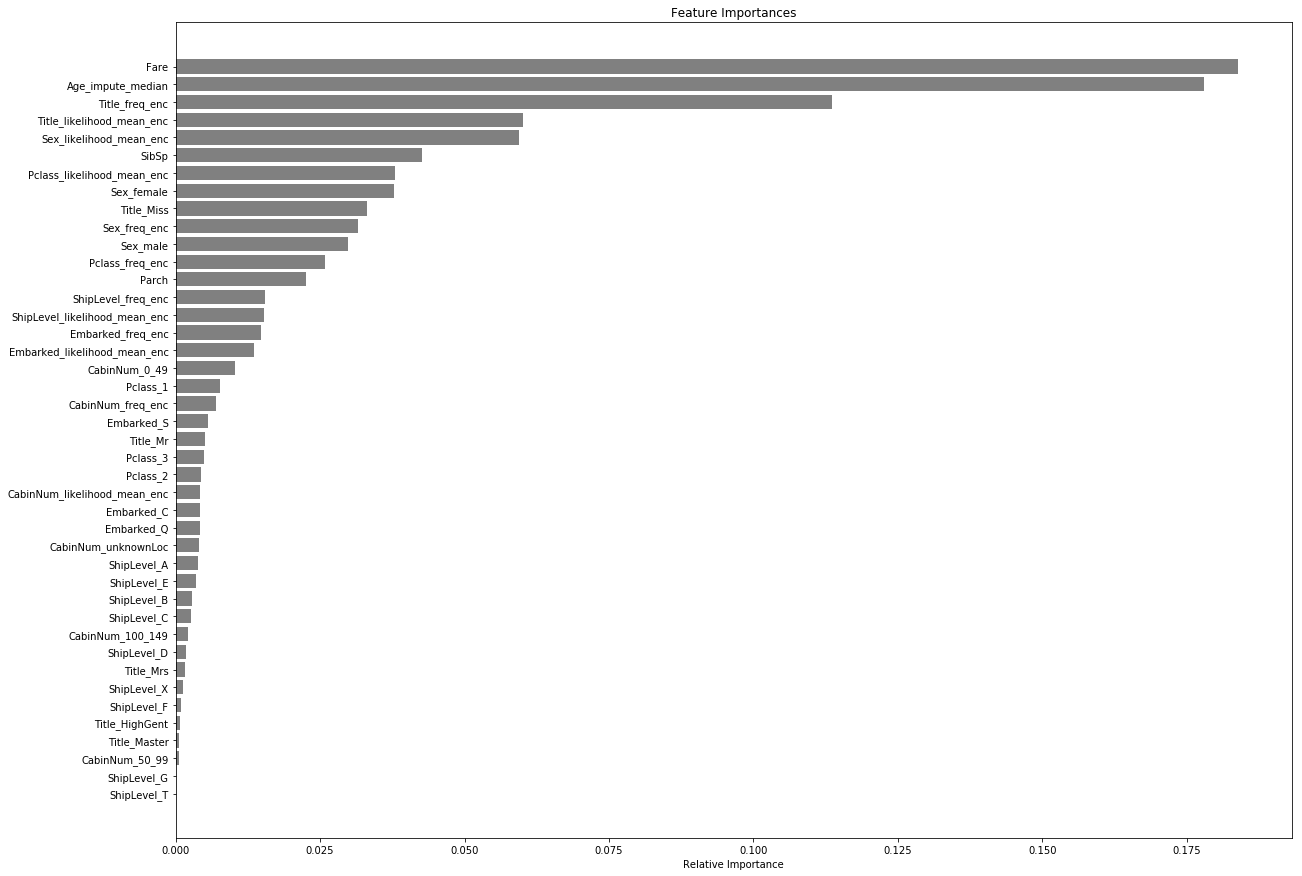

In [222]:
features = X_train.columns
importances = rf_model.steps[0][1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,15))
plt.title('Feature Importances')
container = plt.barh(range(len(indices)), importances[indices], color='grey', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')


plt.show()

In [228]:
featimp.sort_values(by='feat_importance', ascending=False, inplace=True)

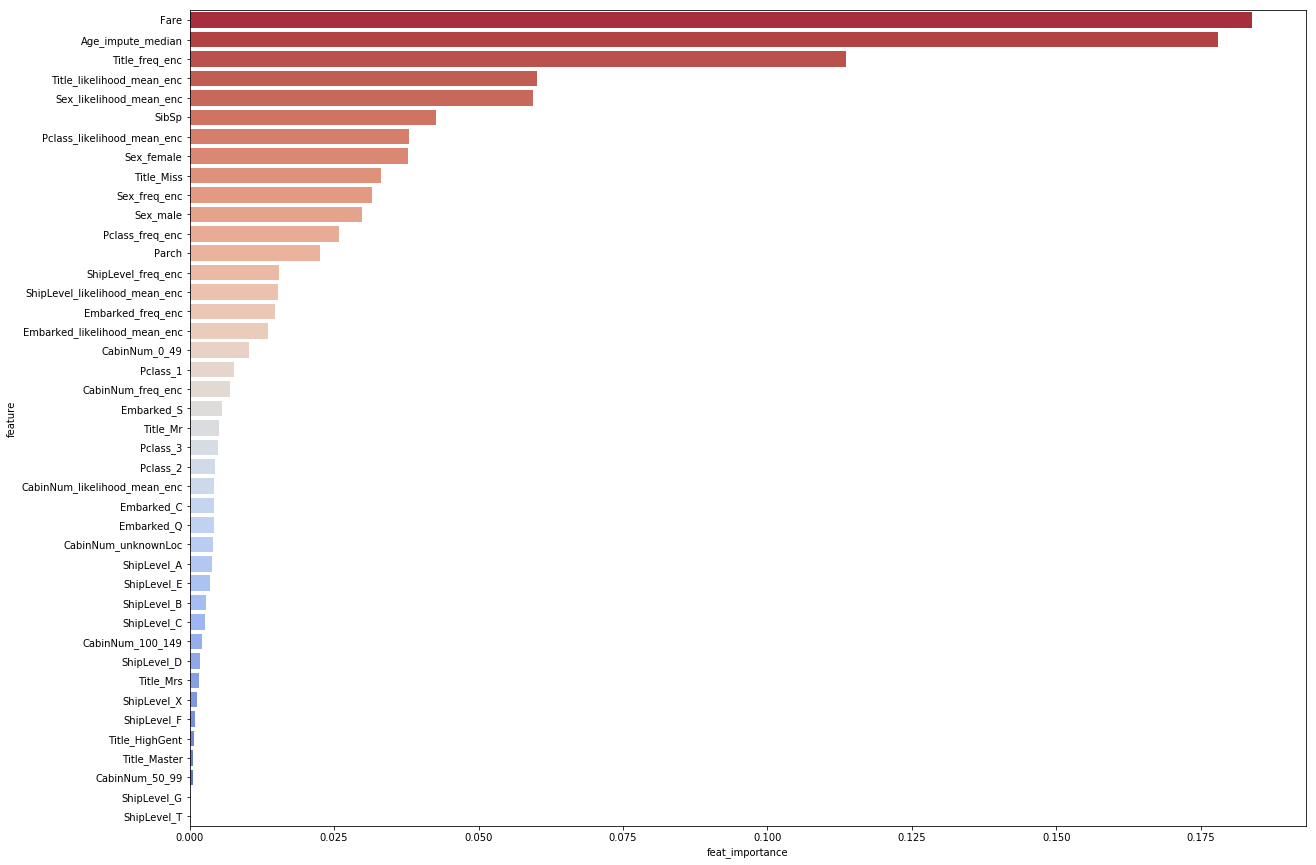

In [230]:
plt.figure(figsize=(20,15))
b = sns.barplot(x=featimp['feat_importance'], y=featimp['feature'], palette='coolwarm_r')

In [114]:
from sklearn.decomposition import PCA

In [115]:
pca = PCA(n_components=3)
X_r = pca.fit(X_train).transform(X_train)

In [116]:
X_r.shape

(616, 3)

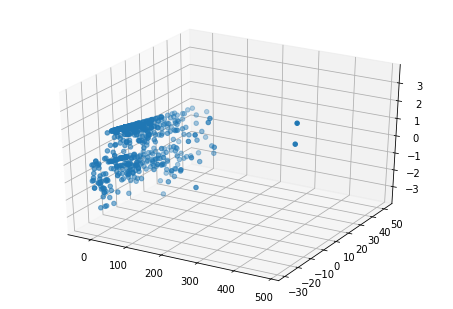

In [117]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X_r[:,0], X_r[:,1], X_r[:,2])
plt.show()


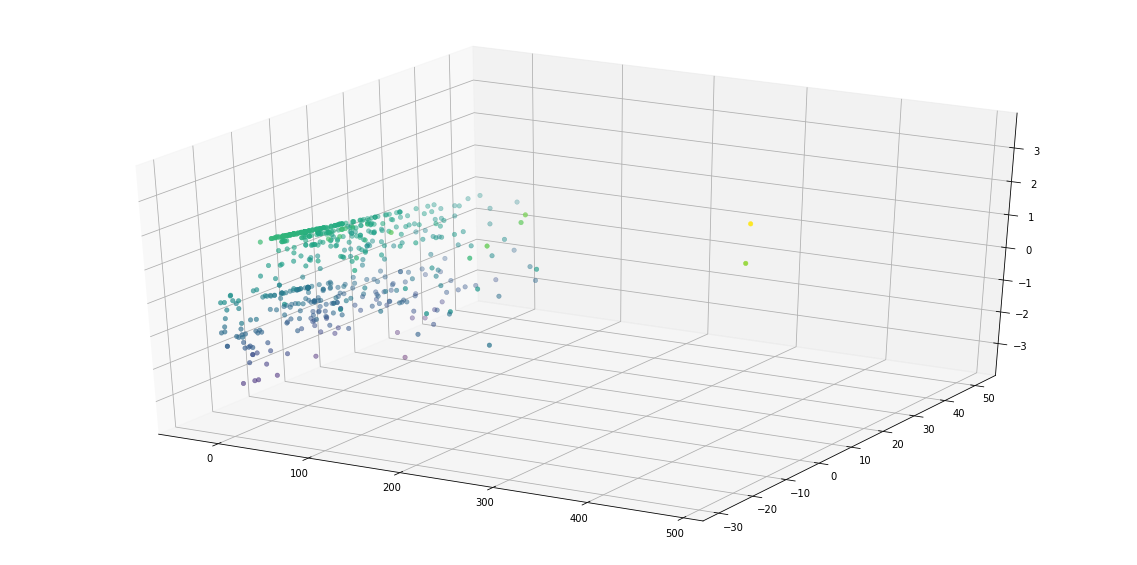

In [118]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter(X_r[:,0], X_r[:,1], X_r[:,2], c=X_r[:,2], cmap='viridis', linewidth=0.5);

In [119]:
from sklearn import manifold

In [120]:
tsne = manifold.TSNE(n_components=3, init='random', random_state=0, perplexity=20)

In [121]:
data_tsne = tsne.fit_transform(X_train)

In [122]:
data_tsne = pd.concat([pd.DataFrame(data_tsne), y_train], axis=1)

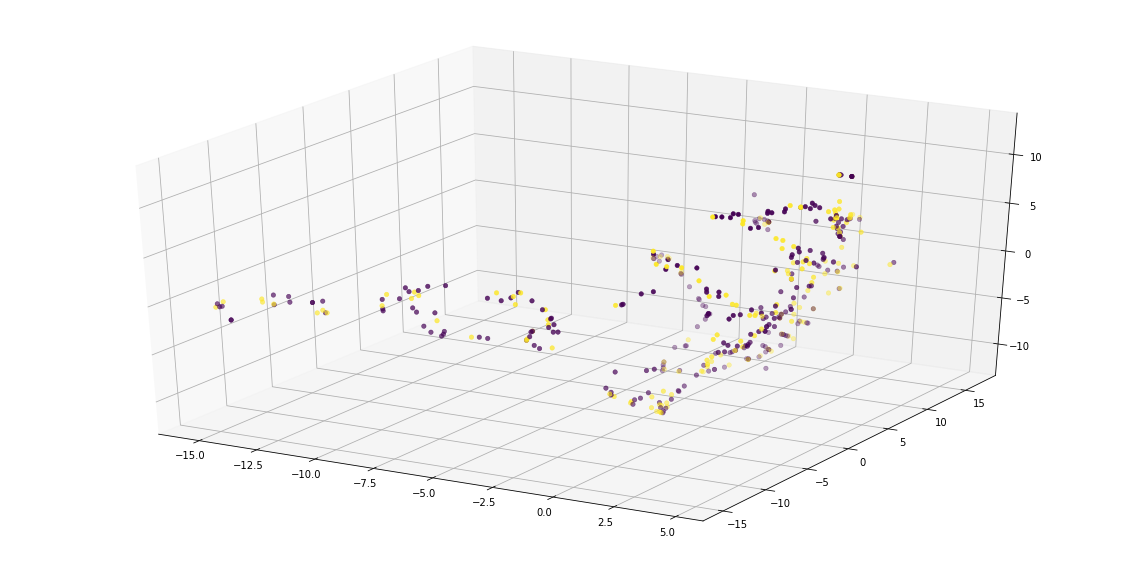

In [123]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter(data_tsne[0], data_tsne[1], data_tsne[2], c=data_tsne['Survived'], cmap='viridis', linewidth=0.5);

In [124]:
def tsne_2d_plot_save(X_data, y_data, perplexity, learning_rate):
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, 
                         perplexity=perplexity, learning_rate=learning_rate)
    data_tsne = tsne.fit_transform(X_data)
    data_tsne = pd.concat([pd.DataFrame(data_tsne), y_data], axis=1)
    
    tsne_survived = data_tsne[data_tsne['Survived']==1]
    tsne_notsurvived = data_tsne[data_tsne['Survived']==0]
    
    plt.figure(figsize=(20,10))
    plt.plot(tsne_survived[0], tsne_survived[1], '.')
    plt.plot(tsne_notsurvived[0], tsne_notsurvived[1], '.')
    
    filename = str('titanic_tsne_perpl_'+str(perplexity)+'_learrat_'+str(learning_rate)+'_')
    i = 0
    while os.path.exists('{}{:d}.png'.format(filename, i)):
        i += 1
    plt.savefig('{}{:d}.png'.format(filename, i))
    
#tsne_2d_plot_save(X_data=X_train, y_data=y_train, perplexity=20, learning_rate=10)

In [125]:
#for perplexity in np.arange(2, 500, 10):
#    for learning_rate in np.arange(10, 100, 10):
#        tsne_2d_plot_save(X_data=X_train, y_data=y_train, perplexity=perplexity, learning_rate=learning_rate)

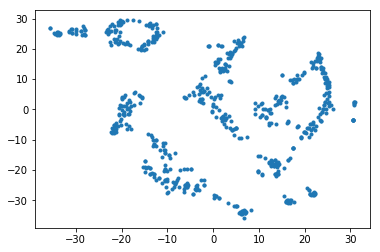

In [126]:
tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=20, learning_rate=10)
data_tsne = tsne.fit_transform(X_train)
data_tsne = pd.concat([pd.DataFrame(data_tsne), y_train], axis=1)


plt.plot(data_tsne[0], data_tsne[1], '.')

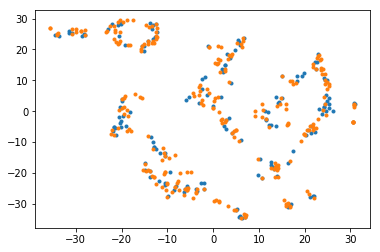

In [127]:
tsne_survived = data_tsne[data_tsne['Survived']==1]
tsne_notsurvived = data_tsne[data_tsne['Survived']==0]

plt.plot(tsne_survived[0], tsne_survived[1], '.')
plt.plot(tsne_notsurvived[0], tsne_notsurvived[1], '.')

## Framework with Class

In [128]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [129]:
from sklearn.model_selection import KFold

In [130]:
# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, random_state=SEED)

In [131]:
oof_train = np.zeros((ntrain,))  # shape (881,)
oof_test = np.zeros((ntest,))    # shape (418,)
oof_test_skf = np.empty((NFOLDS, ntest))  # shape (5, 418)

In [132]:
oof_test_skf

array([[  1.28761735e-311,   1.28761882e-311,   7.74860419e-304, ...,
          7.74860419e-304,   7.74860419e-304,   7.74860419e-304],
       [  7.74860419e-304,   7.74860419e-304,   7.74860419e-304, ...,
          7.74860419e-304,   7.74860419e-304,   7.74860419e-304],
       [  7.74860419e-304,   7.74860419e-304,   7.74860419e-304, ...,
          7.74860419e-304,   7.74860419e-304,   7.74860419e-304],
       [  7.74860419e-304,   7.74860419e-304,   7.74860419e-304, ...,
          7.74860419e-304,   7.74860419e-304,   7.74860419e-304],
       [  7.74860419e-304,   7.74860419e-304,   7.74860419e-304, ...,
          7.74860419e-304,   7.74860419e-304,   7.74860419e-304]])

In [133]:
oof_test_skf.shape

(5, 265)

In [134]:
kf

KFold(n_splits=616, random_state=0, shuffle=False)

In [135]:
X_train.shape

(616, 42)

In [136]:
kf = KFold(3)

def get_oof(clf, X_train, y_train, X_test):
    for k, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        print(train.shape)
        x_tr = X_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = X_test.iloc[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i,:] = clf.predict(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

In [137]:
X_train.shape

(616, 42)

In [138]:
X_train.tail()

,SibSp,Parch,Fare,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_HighGent,Title_Master,Title_Miss,Title_Mr,Title_Mrs,ShipLevel_A,ShipLevel_B,ShipLevel_C,ShipLevel_D,ShipLevel_E,ShipLevel_F,ShipLevel_G,ShipLevel_T,ShipLevel_X,CabinNum_0_49,CabinNum_50_99,CabinNum_100_149,CabinNum_unknownLoc
106,0,0,7.8958,38.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
270,1,0,77.9583,63.0,0.246343,0.629108,0.354888,0.747573,0.69746,0.341195,0.200924,0.712707,0.035412,0.757576,0.128560,0.698276,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
860,0,0,7.8958,26.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
435,1,0,7.7750,25.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
102,2,0,7.9250,37.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [139]:
X_test.shape

(265, 42)

In [140]:
X_all = pd.concat([X_train, X_test], axis=0)
X_all.shape

(881, 42)

In [141]:
X_all.head()

,SibSp,Parch,Fare,Age_impute_median,Pclass_freq_enc,Pclass_likelihood_mean_enc,Sex_freq_enc,Sex_likelihood_mean_enc,Embarked_freq_enc,Embarked_likelihood_mean_enc,Title_freq_enc,Title_likelihood_mean_enc,ShipLevel_freq_enc,ShipLevel_likelihood_mean_enc,CabinNum_freq_enc,CabinNum_likelihood_mean_enc,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_HighGent,Title_Master,Title_Miss,Title_Mr,Title_Mrs,ShipLevel_A,ShipLevel_B,ShipLevel_C,ShipLevel_D,ShipLevel_E,ShipLevel_F,ShipLevel_G,ShipLevel_T,ShipLevel_X,CabinNum_0_49,CabinNum_50_99,CabinNum_100_149,CabinNum_unknownLoc
90,1,0,61.1750,46.0,0.246343,0.629108,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.031563,0.750000,0.128560,0.698276,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
825,0,0,7.8542,23.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
181,0,0,50.0000,39.0,0.246343,0.629108,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.016936,0.466667,0.128560,0.698276,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
786,0,0,7.8958,25.0,0.540416,0.245868,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
69,0,0,10.5000,32.0,0.213241,0.472826,0.645112,0.190559,0.69746,0.341195,0.581216,0.157282,0.775212,0.302941,0.785219,0.303779,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [142]:
clf=SklearnHelper(clf=ensemble.RandomForestClassifier, seed=SEED, params=rf_params)

for i, (train_index, test_index) in enumerate(kf.split(X_all, y_train)):
    print(train.shape)
    x_tr = X_all.iloc[train_index]
    y_tr = y_train.iloc[train_index]
    x_te = X_all.iloc[test_index]
        
    clf.train(x_tr, y_tr)
        
    oof_train[test_index] = clf.predict(x_te)
    oof_test_skf[i,:] = clf.predict(X_test)

oof_test[:] = oof_test_skf.mean(axis=0)
    #return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

NameError: name 'rf_params' is not defined

In [ ]:
train

In [ ]:
clf=SklearnHelper(clf=ensemble.RandomForestClassifier, seed=SEED, params=rf_params)
clf = ensemble.GradientBoostingClassifier(**params)
params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
n_estimators = params['n_estimators']

def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score

def cv_estimate(n_splits=3):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        clf.fit(X_train.iloc[train], y_train.iloc[train])
        val_scores += heldout_score(clf, X_train.iloc[test], y_train.iloc[test])
    val_scores /= n_splits
    return val_scores

# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)        
clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

In [ ]:
oof_test_skf

In [ ]:
oof_test_skf

In [ ]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

In [ ]:
rf = SklearnHelper(clf=ensemble.RandomForestClassifier, seed=SEED, params=rf_params)

In [ ]:
rf_oof_train, rf_oof_test = get_oof(rf, X_train, y_train, X_test) # Random Forest

In [ ]:
X_test.tail()

In [ ]:
X_train.tail()